In [1]:
locations = readdlm("locations.csv", ',')
city  = locations[2:end, 1]
lat   = locations[2:end, 3]
lon   = locations[2:end, 4]
score = locations[2:end, 5]
city_lat   = Dict(zip(city, lat))
city_lon   = Dict(zip(city, lon))
city_score = Dict(zip(city, score))
city_number = size(city, 1)
city_day_upperlimit = ones(city_number, 1) * 3
city_day_upperlimit[city_number] = 1

flights  = readdlm("flights.csv", ',')
departure_city    = flights[2:end, 1]
departure_airport = flights[2:end, 2]
arrival_city      = flights[2:end, 3]
arrival_airport   = flights[2:end, 4]
flight_date       = flights[2:end, 5]
flight_price      = flights[2:end, 6]
flight_comfort    = flights[2:end, 7]
flight_number     = size(flights, 1) - 1

# max amout of money spend on flight
max_money = 100000;
# max travel days
max_day = 10;

matrix = zeros(2city_number,2city_number + flight_number);
# split each city into two 'subcities'
for i = 1 : city_number
    matrix[2i-1, 2i-1] = 1
    matrix[2i  , 2i-1] = -1
    
    matrix[2i-1, 2i] = -1
    matrix[2i  , 2i] = 1
end
for i = 1 : flight_number
    u = 1
    v = 1
    for j = 1 : city_number
        if departure_city[i] == city[j]
            u = j
        end
        if arrival_city[i] == city[j]
            v = j
        end
    end
    matrix[2u  ,i+2city_number] = 1
    matrix[2v-1,i+2city_number] = -1
end

b = zero(1:2city_number);
b[2city_number-1] = -1;
b[2city_number] = 1;

In [40]:
using PyPlot
using PyCall
@pyimport mpl_toolkits.basemap as basemap

function mapSolution(x=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=22,llcrnrlon=-130,urcrnrlat=52,urcrnrlon=-60)
    lightBlue = (220/255, 220/255, 255/255)
    lightGreen = (230/255, 255/255, 230/255)
    m[:drawcoastlines](linewidth=0.5)
    m[:drawcountries](linewidth=0.25)
    m[:drawmapboundary](fill_color=lightBlue)
    m[:fillcontinents](color=lightGreen, lake_color=lightBlue)
    
    # m[:drawmeridians](collect(-180:20:180), labels=[1,1,0,1])
    # m[:drawparallels](collect(10:10:90), labels=[1,1,0,1])

    # plot airports
    for i in city
        m[:plot](city_lon[i], city_lat[i], "ro" ,latlon=true)
    end

    # plot tours
    if x==0
        return
    else
        for i = 1 : 2city_number + flight_number
            if x[i] > 0
                if i<= 2city_number && i%2 == 1
                    continue
                end
                u , v = get_city_from_edge(i)
                if (u == v)
                    m[:plot](city_lon[city[u]], city_lat[city[u]], "bo" ,latlon=true)
                else
                    m[:drawgreatcircle](city_lon[city[u]],city_lat[city[u]],city_lon[city[v]],city_lat[city[v]],linewidth=1,color="b")
                end
            end
        end
    end
end;

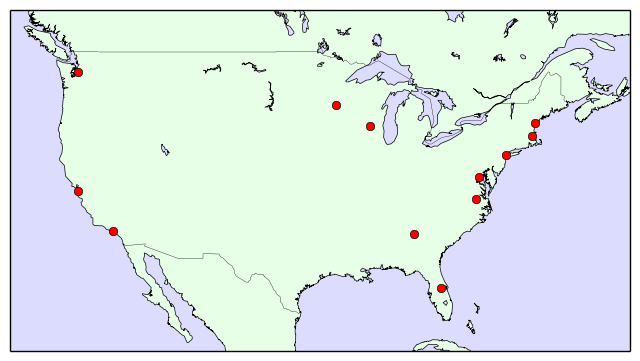

In [14]:
mapSolution(0)

In [16]:
sols[1]

420-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [3]:
function getInitialEdge(remaining)
    len = size(remaining)[1];
    for i in 1:len
        edge_no = remaining[i]
        # MODIFIED
        if matrix[2*city_number, edge_no] == 1
            return i
        end
    end
    return 1
end

function get_city_from_edge(no)
    arr = matrix[:,no]
    u = 0
    v = 0
    for i = 1 : 2city_number
        if arr[i] == 1
            u = round(Int,ceil(i/2));
        end
        if arr[i] == -1
            v = round(Int,ceil(i/2));
        end
    end
    return u, v
end

# print all the edges, including flight and circle for one city itself
function print_out_edge(edge)
    for i = 1 : 2city_number + flight_number
        if edge[i] > 0
            if i<= 2city_number && i%2 == 1
                continue
            end
            u , v = get_city_from_edge(i)
            print(i, " ", city[u], "  to  ", city[v],'\n')
        end
    end
end

# print all the flights
function print_out_flight(flight)
    for i = 1 : flight_number
        if flight[i] > 0
            print(i,' ',departure_city[i], "  to   ", arrival_city[i], " \n");
        end
    end
end

# HELPER FUNCTION: returns the cycle containing the city START.
function getSubtour(edge_remaining, start_edge)
    subtour = [start_edge];
    start_u, start_v = get_city_from_edge(edge_remaining[start_edge]);

    pre_u = start_u;
    pre_v = start_v;
    while true
        for i = 1 : size(edge_remaining)[1]
            if i in subtour
                continue
            end
            temp_u, temp_v = get_city_from_edge(edge_remaining[i]);
            if temp_u == pre_v
                push!(subtour, i);
                pre_u = temp_u;
                pre_v = temp_v;
                break
            end
        end
        if pre_v == start_u
            break
        end
    end
    return subtour;
end

# HELPER FUNCTION: returns a list of all cycles
function getAllSubtours(edge_chosen_list)
    edge_remaining = edge_chosen_list;
    subtours = [];
    while length(edge_remaining) > 0
        initial_edge_in_remaining_list = getInitialEdge(edge_remaining);
        subtour = getSubtour(edge_remaining, initial_edge_in_remaining_list);
        # the subtour contains only the number in remaining list
        # Ex. if remaining list = [ 10 12 4 7], and [10 4] is a cycle, then subtour here is [1 3]
        push!(subtours, edge_remaining[subtour]);
        edge_remaining = setdiff(edge_remaining, edge_remaining[subtour]);
    end
    return subtours;
end


getAllSubtours (generic function with 1 method)

In [11]:
using JuMP

m = Model()
# city that will spend some days to travel
@defVar(m, city_choice[1:city_number], Bin)
# flight that will be chosen
@defVar(m, flight_choice[1:flight_number], Bin)
# edge consists of 11 pairs of split sub-cities, and 320 flights
@defVar(m, edge[1:2city_number + flight_number], Bin)
# time spent on each city
@defVar(m, day_each_city[1:city_number] >= 0, Int)

# first 22 of edges should match the city_choice
# MODIFIED
@addConstraint(m, c1[i=1:city_number - 1], edge[2i-1] == city_choice[i])
# the remaining edges should match the flight
@addConstraint(m, c2[i=1:flight_number], edge[i+2city_number] == flight_choice[i])

# should be a round trip
@addConstraint(m, matrix * edge .== b)
# each point should have at most one out degree and one in degree
@addConstraint(m, abs(matrix) * edge .<= 2)
# @addConstraint(m, city_choice[city_number] == 1)
# restriced by money limit
@addConstraint(m, sum{flight_choice[i] * flight_price[i], i=1:flight_number} <= max_money)
# restricted by travel day limit
# assumption: spend two days at each city, and one day on each flight
@addConstraint(m,  sum(day_each_city) + sum(flight_choice) <= max_day)

# day spent on each city should be less than its upper limit
# MODIFIED

@addConstraint(m, constr[i in 1:city_number], day_each_city[i] <= city_day_upperlimit[i] * city_choice[i])
@addConstraint(m, constr[i in 1:city_number], day_each_city[i] >= city_choice[i])

# try to max the comfortable indexes
@setObjective(m, Max, sum{score[i]*day_each_city[i], i=1:city_number} + sum{flight_comfort[i] * flight_choice[i], i=1:flight_number})


sols = []

for iter = 1 : 30
    solve(m)
    print("current comfort is :  ", getObjectiveValue(m),'\n')
    print("current day is : ", sum(getValue(day_each_city)) + sum(getValue(flight_choice)),'\n')
    print(getValue(city_choice),'\n')
    print(getValue(day_each_city),'\n')
#    print(getValue(edge[1:22]),'\n')
    edge_choice_exist = getValue(edge)
    edge_chosen_list = []
    for i = 1 : flight_number+2city_number
        if edge_choice_exist[i] > 0
            push!(edge_chosen_list, i)
        end
    end
    subtours = getAllSubtours(edge_chosen_list)
    # subtours is a big map
    for subtour in subtours
        print("subtour :  \n")
        print(subtour,'\n')
        L = length(subtour);
        @addConstraint(m, sum{edge[subtour[i]], i = 1:L} <= L-1)
    end
    print('\n')
    #print_out_tour(getValue(flight_choice))
    print('\n')
    print_out_edge(getValue(edge))
    push!(sols,getValue(edge))
    print('\n')
    print('\n')
    len = length(subtours)
    if len == 1
        print("solved")
        break
    end
end


current comfort is :  846.0
current day is : 10.0
[1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0]
[3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0]
subtour :  
Any[24]
subtour :  
Any[1,2]
subtour :  
Any[3,4]
subtour :  
Any[13,14]
subtour :  
Any[19,20]


2 New York  to  New York
4 Boston  to  Boston
14 Miami  to  Miami
20 San Francisco  to  San Francisco
24 Madison  to  Madison


current comfort is :  656.0191666666667
current day is : 10.0
[1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
[3.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
subtour :  
Any[388,1,55]
subtour :  
Any[5,6]
subtour :  
Any[7,8]


6 Washington D.C.  to  Washington D.C.
8 Chicago  to  Chicago
55 New York  to  Madison
388 Madison  to  New York


current comfort is :  623.01
current day is : 10.0
[1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]
[3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0]
subtour :  
Any[388,1,56]
subtour :  
Any[9,10]
subtour :  
Any[21,22]


10 Minneapolis  to  Minneapolis
22 Seattl

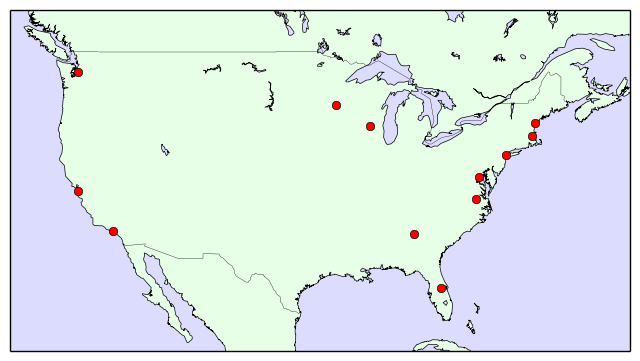

In [12]:
mapSolution(sols[1])

In [21]:
sols

5-element Array{Any,1}:
 [1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
 [1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
 [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
 [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
 [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]

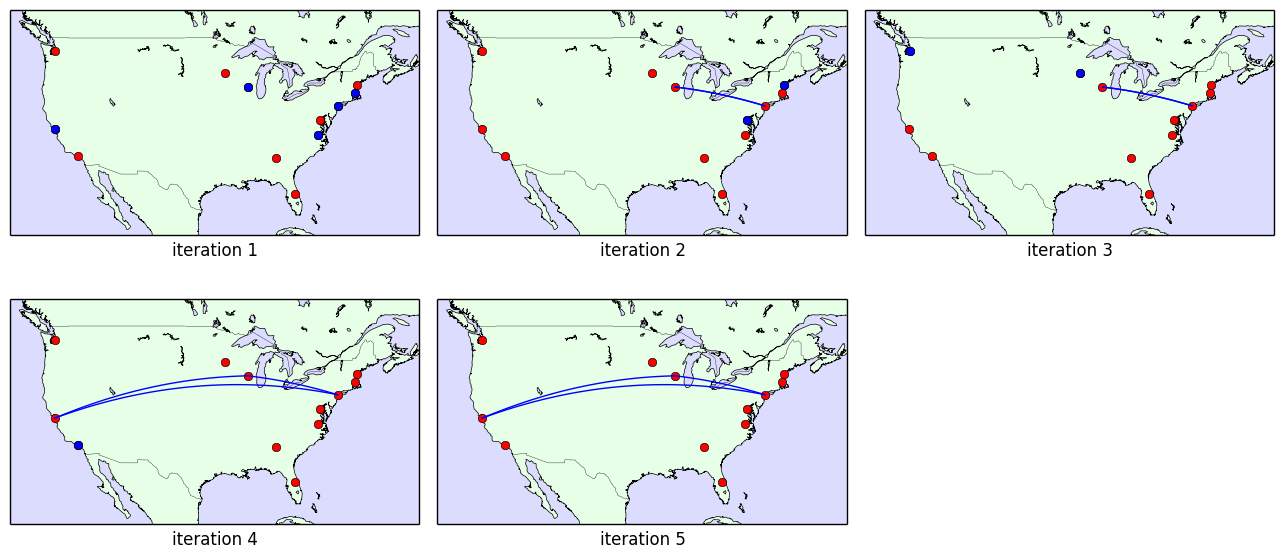

In [41]:
# plot the iterations as we eliminate subtours
figure(figsize=(13,6))
for i = 1:5
    subplot(2,3,i)
    mapSolution(sols[i])
    xlabel(string("iteration ",i))
end
tight_layout()
#savefig("tsp_sol_elim.pdf")